### Project title: Explicating Money Laundering: Employing AI to solve Financial Crimes.
### Objective: The project seeks to create a data-driven solution to combat illicit transactions related to money laundering in the banking fratenity.
### Key target values:
- Label: This is an indicator that flags transactions as money laundering.
- USD amount: The total amount of money being transferred to the beneficiary.
- Transaction type: Varying types of sources/actions used to transact money.


### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from collections import Counter
import scipy
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification

### Read the dataset

In [48]:
data = pd.read_csv('aml_syn_data.txt')
data.head()

,Time_step,Label,Transaction_Id,Sender_Id,Sender_Account,Sender_Institution,Sender_Country,USD_amount,Bene_Id,Bene_Account,Bene_Institution,Bene_Country,Transaction_Type
0,2022-01-07 00:02:00,GOOD,T-174791-02,JPMC-CLIENT-174571-02,CHECKING-174582-02,JPMORGANCHASE,USA,0.00,CUSTOMER-174577-02,CHECKING-174582-02,JPMORGANCHASE,USA,KYC-ADD-ACCOUNT-OWNER
1,2022-01-07 00:02:00,GOOD,T-105637-03,JPMC-CLIENT-105413-03,CHECKING-105426-03,JPMORGANCHASE,USA,0.00,CUSTOMER-105419-03,CHECKING-105426-03,JPMORGANCHASE,USA,KYC-ADD-ACCOUNT-OWNER
2,2022-01-07 00:02:00,GOOD,T-235858-04,COMPANY-235572-04,CHECKING-235577-04,JPMORGANCHASE,USA,0.00,JPMC-CLIENT-235567-04,CHECKING-235577-04,JPMORGANCHASE,USA,KYC-ADD-ACCOUNT-OWNER
3,2022-01-07 00:02:00,GOOD,T-379320-02,JPMC-CLIENT-379064-02,CHECKING-379071-02,BANK-379167-02,USA,68.35,OWNER-379114-02,CHECKING-379117-02,JPMORGANCHASE,USA,WIRE
4,2022-01-07 00:02:00,GOOD,T-413316-04,JPMC-CLIENT-413218-04,CHECKING-413226-04,JPMORGANCHASE,USA,0.00,CUSTOMER-413224-04,CHECKING-413226-04,JPMORGANCHASE,USA,KYC-ADD-ACCOUNT-OWNER


### Data Preprocessing

In [49]:
# Rename column 'Label' to 'Is_ML'
data.rename(columns = {"Label" : "Is_ML"}, inplace=True)

In [50]:
# Change the values of the renamed colomn:
data["Is_ML"] = data["Is_ML"].replace({"GOOD": 0, "BAD": 1})

In [51]:
# Drop columns not neccesary for analysis
data = data.drop(["Sender_Id", "Bene_Id"], axis=1)

In [52]:
#Split Time_step into time and date

data.Time_step.str.split(expand=True)
data[["Date", "Time"]] = data.Time_step.str.split(expand=True)
data.tail()

,Time_step,Is_ML,Transaction_Id,Sender_Account,Sender_Institution,Sender_Country,USD_amount,Bene_Account,Bene_Institution,Bene_Country,Transaction_Type,Date,Time
1484531,2027-11-05 17:55:00,0,T-303364-08,NaN,NaN,NaN,9500.93,CHECKING-302747-08,JPMORGANCHASE,USA,CASH-DEPOSIT,2027-11-05,17:55:00
1484532,2027-11-06 03:56:00,0,T-303369-08,NaN,NaN,NaN,9500.87,CHECKING-302747-08,JPMORGANCHASE,USA,CASH-DEPOSIT,2027-11-06,03:56:00
1484533,2027-12-01 03:18:00,0,T-303347-08,NaN,NaN,NaN,9500.28,CHECKING-302747-08,JPMORGANCHASE,USA,CASH-DEPOSIT,2027-12-01,03:18:00
1484534,2027-12-02 01:16:00,0,T-981700-10,CHECKING-981105-10,JPMORGANCHASE,USA,5000.64,NaN,NaN,NaN,WITHDRAWL,2027-12-02,01:16:00
1484535,2027-12-04 13:20:00,0,T-981709-10,CHECKING-981105-10,JPMORGANCHASE,USA,5000.24,NaN,NaN,NaN,WITHDRAWL,2027-12-04,13:20:00


In [53]:
# Check the shape of the data
print(f"This dataset contains:\nThe number of rows: {data.shape[0]}\nThe number of columns: {data.shape[1]}")

This dataset contains:
The number of rows: 1484536
The number of columns: 13


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484536 entries, 0 to 1484535
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Time_step           1484536 non-null  object 
 1   Is_ML               1484536 non-null  int64  
 2   Transaction_Id      1484536 non-null  object 
 3   Sender_Account      1119436 non-null  object 
 4   Sender_Institution  1119436 non-null  object 
 5   Sender_Country      1119436 non-null  object 
 6   USD_amount          1484536 non-null  float64
 7   Bene_Account        921185 non-null   object 
 8   Bene_Institution    921185 non-null   object 
 9   Bene_Country        921185 non-null   object 
 10  Transaction_Type    1484536 non-null  object 
 11  Date                1484536 non-null  object 
 12  Time                1484536 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 147.2+ MB


In [55]:
data.nunique()

Time_step              333807
Is_ML                       2
Transaction_Id        1484536
Sender_Account          68636
Sender_Institution      19864
Sender_Country             30
USD_amount             666978
Bene_Account           183479
Bene_Institution        59372
Bene_Country               33
Transaction_Type            7
Date                     1708
Time                      675
dtype: int64

In [56]:
# Loop through each column to print value labels
for col in data.columns:
    if col != "Time":
        print(f"{col}: {data[col].unique()}\n")

Time_step: ['2022-01-07 00:02:00' '2022-01-07 00:06:00' '2022-01-07 00:10:00' ...
 '2027-12-01 03:18:00' '2027-12-02 01:16:00' '2027-12-04 13:20:00']

Is_ML: [0 1]

Transaction_Id: ['T-174791-02' 'T-105637-03' 'T-235858-04' ... 'T-303347-08' 'T-981700-10'
 'T-981709-10']

Sender_Account: ['CHECKING-174582-02' 'CHECKING-105426-03' 'CHECKING-235577-04' ...
 'CHECKING-1668585-06' 'CHECKING-1324237-04' 'CHECKING-302747-08']

Sender_Institution: ['JPMORGANCHASE' 'BANK-379167-02' 'BANK-1718317-04' ... 'BANK-936403-06'
 'BANK-901505-00' 'BANK-1668809-06']

Sender_Country: ['USA' nan 'UNITED-KINGDOM' 'ISRAEL' 'MEXICO' 'QATAR' 'SOUTH-AFRICA'
 'ISLE-OF-MAN' 'CANADA' 'SWITZERLAND' 'SOUTH-KOREA' 'LUXEMBOURG' 'GERMANY'
 'CHILE' 'VENEZUELA' 'RUSSIA' 'ITALY' 'MAROCCO' 'AUSTRALIA'
 'VIRGIN-ISLANDS-US' 'SWEDEN' 'NIGERIA' 'ARGENTINA' 'INDIA' 'NICARAGUA'
 'PORTUGAL' 'SPAIN' 'PANAMA' 'SINGAPORE' 'FRANCE' 'CHINA']

USD_amount: [   0.     68.35  869.06 ... 8627.08 8774.11 6059.34]

Bene_Account: ['CHECKING-

### Statistical analysis

In [57]:
data.describe()

,Is_ML,USD_amount
count,1.484536e+06,1.484536e+06
mean,2.094594e-01,1.340852e+05
std,4.069229e-01,3.967556e+05
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,8.358000e+02
50%,0.000000e+00,5.000150e+03
75%,0.000000e+00,9.464050e+03
max,1.000000e+00,1.930000e+07


### Data cleaning

In [58]:
# Check for null values
null_values = data.isnull().sum()
null_percent = data.isnull().sum()/data.shape[0]*100
null_info = pd.DataFrame({"Null values": null_values, "Null Percentage": round((null_percent),2)})
print(null_info)

                    Null values  Null Percentage
Time_step                     0             0.00
Is_ML                         0             0.00
Transaction_Id                0             0.00
Sender_Account           365100            24.59
Sender_Institution       365100            24.59
Sender_Country           365100            24.59
USD_amount                    0             0.00
Bene_Account             563351            37.95
Bene_Institution         563351            37.95
Bene_Country             563351            37.95
Transaction_Type              0             0.00
Date                          0             0.00
Time                          0             0.00


In [59]:
#Replace missing values with the mode in every categorical column
null_columns = ["Sender_Account", "Sender_Institution", "Sender_Country",
                "Bene_Account", "Bene_Institution", "Bene_Country"]

for i,var in enumerate(null_columns):
    data[var].fillna(data[var].mode(), inplace=True)

In [60]:
#Check if there any duplicates
data.duplicated().sum()

0

### Exploratory Data Analysis

#### What is the distribution of Is_ML?

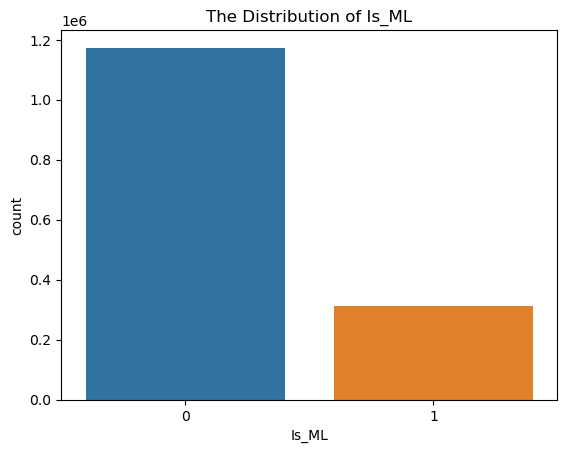

In [61]:
# Check the distribution of the target label class
sns.countplot(x="Is_ML", data=data).set_title("The Distribution of Is_ML")
plt.show()

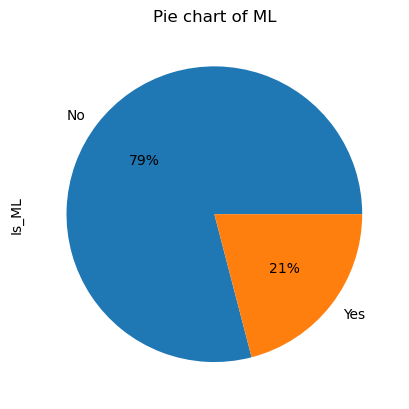

In [62]:
# Check the values counts using a pie chart
data["Is_ML"].value_counts().plot(kind="pie", autopct="%1.f%%", labels=["No", "Yes"])
plt.title("Pie chart of ML")
plt.show()

In [63]:
# Percentage of each class sample distribution
print("Transactions that are ML fraud:{}%".format(np.round(len(data[data["Is_ML"]==1])/len(data)*100)))
print("Transactions that Not ML fraud: {}%".format(np.round(len(data[data["Is_ML"]==0])/len(data)*100)))

Transactions that are ML fraud:21.0%
Transactions that Not ML fraud: 79.0%


The distribution of the target label for this case indicates an imbalanced binary classification problem. The target lable is considered imbalanced when there is a sigficant varience in the distribution of lables in terms of the count. In this instance, there are significantly more non money laundering transactions than those who are considered as such. This affects the training and predicion of the model. 

#### Total amounts of transactions per year?

In [64]:
#change date to datetime format
data["Date"] = pd.to_datetime(data["Date"])

#extract day, month, and year
data["Day"] = data["Date"].dt.day
data["Month"] = data["Date"].dt.month
data["Year"] = data["Date"].dt.year

In [65]:
data.groupby("Year")["USD_amount"].sum()

Year
2022    5.160529e+10
2023    1.283164e+11
2024    1.876804e+10
2025    3.287449e+08
2026    3.526092e+07
2027    5.426497e+05
Name: USD_amount, dtype: float64

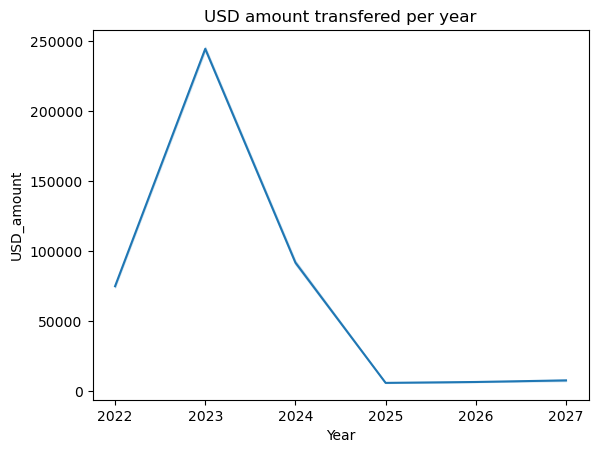

In [66]:
sns.lineplot(x="Year", y="USD_amount", data=data).set_title("USD amount transfered per year")
plt.show()

#### How many of those were flagged as ML?

In [67]:
amount_year = data[data["Is_ML"] == 1]
data.groupby("Year")["USD_amount"].sum()

Year
2022    5.160529e+10
2023    1.283164e+11
2024    1.876804e+10
2025    3.287449e+08
2026    3.526092e+07
2027    5.426497e+05
Name: USD_amount, dtype: float64

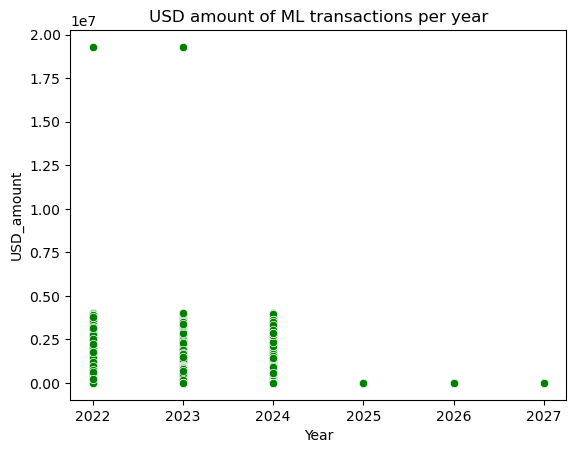

In [68]:
sns.scatterplot(x="Year", y="USD_amount", data=data, color= "green")
plt.title("USD amount of ML transactions per year")
plt.show()

#### What is the total amount of transactions per month?

In [69]:
data["Month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [70]:
# Change the month dtype for analysis purposes
data["Month"] = data["Month"].replace({1: "Jan",
                                     2: "Feb",
                                     3: "Mar",
                                     4: "Apr",
                                     5: "May",
                                     6: "Jun",
                                     7: "Jul",
                                     8: "Aug",
                                     9: "Sep",
                                     10: "Oct",
                                     11: "Nov",
                                     12: "Dec"})

In [71]:
data.groupby("Month")["USD_amount"].sum()

Month
Apr    1.633938e+10
Aug    1.249247e+10
Dec    1.955707e+10
Feb    1.648642e+10
Jan    1.899694e+10
Jul    1.390327e+10
Jun    1.444123e+10
Mar    1.776831e+10
May    1.585153e+10
Nov    1.927133e+10
Oct    1.852404e+10
Sep    1.542233e+10
Name: USD_amount, dtype: float64

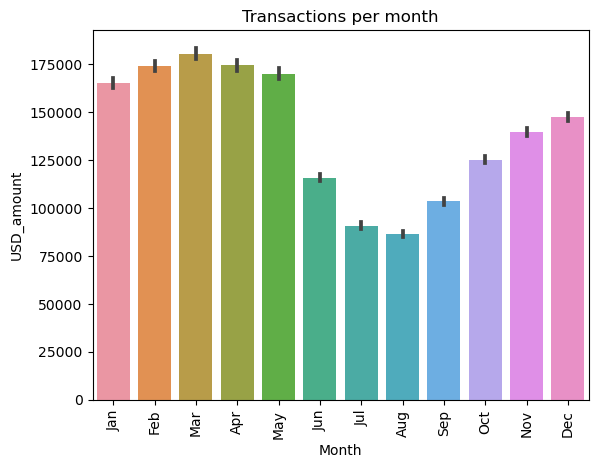

In [72]:
sns.barplot(x="Month", y="USD_amount", data=data).set_title("Transactions per month")
plt.xticks(rotation=90)
plt.show()

#### How many are flagged as ML per month?

In [73]:
amount_month = data[data["Is_ML"] == 1]
data.groupby("Month")["USD_amount"].sum()

Month
Apr    1.633938e+10
Aug    1.249247e+10
Dec    1.955707e+10
Feb    1.648642e+10
Jan    1.899694e+10
Jul    1.390327e+10
Jun    1.444123e+10
Mar    1.776831e+10
May    1.585153e+10
Nov    1.927133e+10
Oct    1.852404e+10
Sep    1.542233e+10
Name: USD_amount, dtype: float64

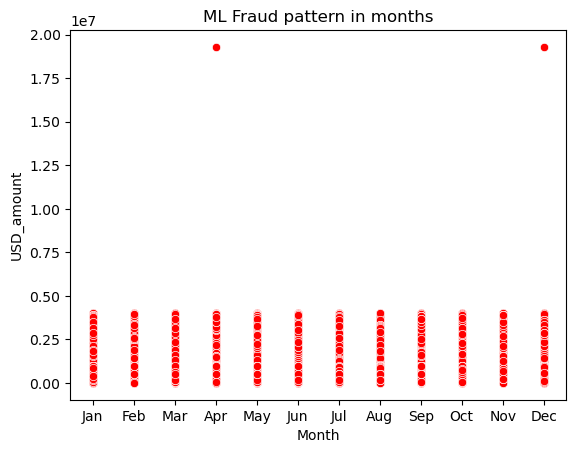

In [74]:
sns.scatterplot(x="Month", y="USD_amount", data=amount_month, color="red")
plt.title("ML Fraud pattern in months")
plt.show()

#### What is the distribution of transaction types in the dataset?

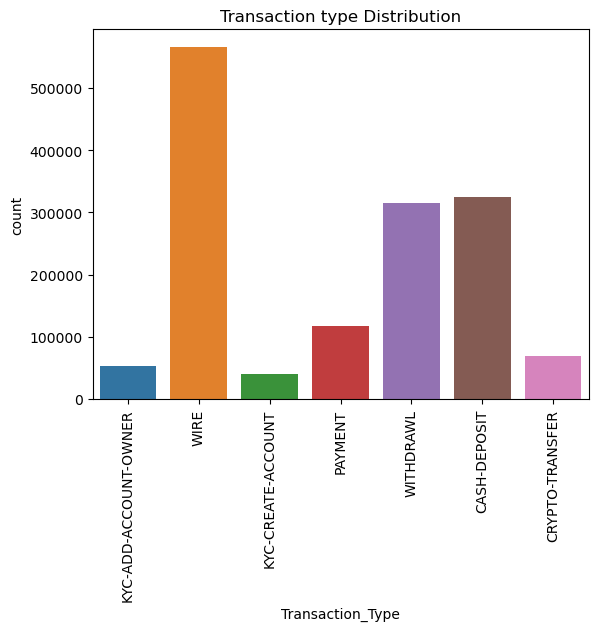

In [75]:
sns.countplot(x='Transaction_Type', data=data).set_title("Transaction type Distribution")
plt.xticks(rotation=90)
plt.show()

#### What is the distribution of ml label in transaction types?

In [76]:
data.groupby("Transaction_Type")["Is_ML"].value_counts()

Transaction_Type       Is_ML
CASH-DEPOSIT           0        211776
                       1        112774
CRYPTO-TRANSFER        1         68900
KYC-ADD-ACCOUNT-OWNER  0         34084
                       1         18738
KYC-CREATE-ACCOUNT     0         31181
                       1          9369
PAYMENT                0         99025
                       1         18221
WIRE                   0        547678
                       1         18167
WITHDRAWL              0        249842
                       1         64781
Name: Is_ML, dtype: int64

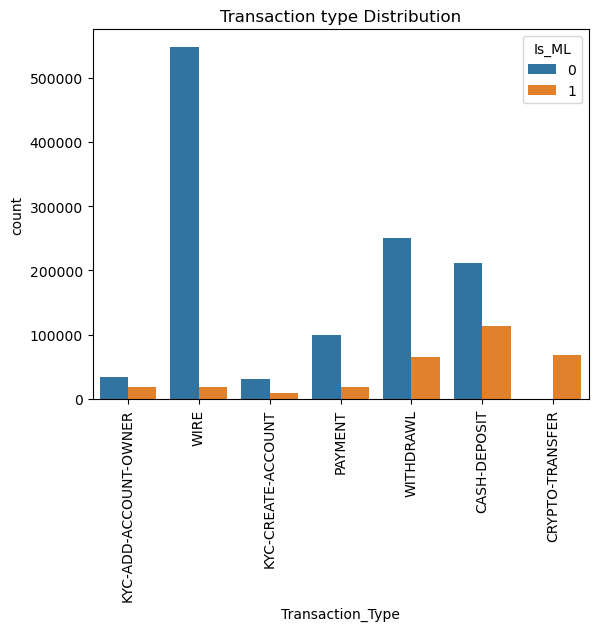

In [77]:
sns.countplot(x='Transaction_Type', data=data, hue="Is_ML").set_title("Transaction type Distribution")
plt.xticks(rotation=90)
plt.show()

Money laundering fraud is higher in cash deposit transactions and significantly lower in kyc create account (know your customer account). This is because kyc accounts identify and verify clients' identity. 


#### Geaographical distribution

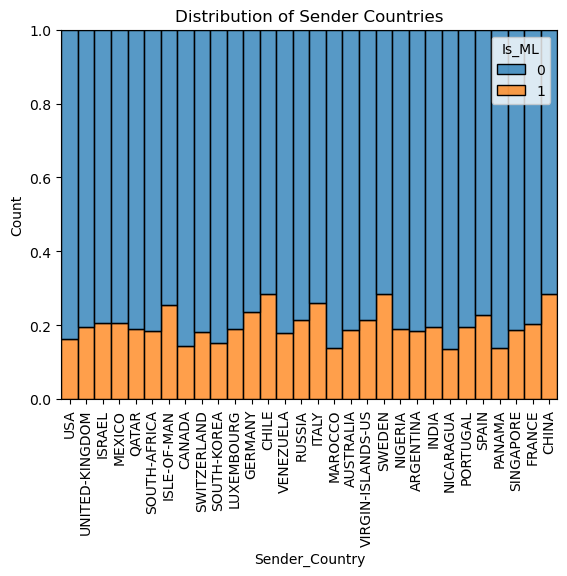

In [78]:
sns.histplot(x="Sender_Country", data=data, hue="Is_ML", multiple="fill")
plt.title("Distribution of Sender Countries")
plt.xticks(rotation=90)
plt.show()

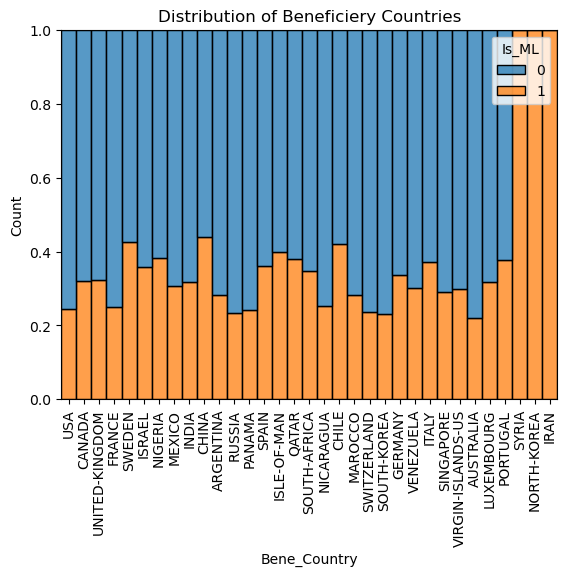

In [79]:
sns.histplot(x="Bene_Country", data=data, hue="Is_ML", multiple="fill")
plt.title("Distribution of Beneficiery Countries")
plt.xticks(rotation=90)
plt.show()

### Label Encoding for object dtypes and Correlation

In [85]:
# Initialise the LableEncoder
encoder = LabelEncoder()

# Loop through the each column in the dataset where the dtype is 'object'
for col in data.select_dtypes(include= "object").columns:
    
    #initialise a labelencoder object:
    label_encoder = preprocessing.LabelEncoder()
    
    #fit the encoder to the unique values in the column:
    label_encoder.fit(data[col].unique())
    
    # Transform the column usinf the encoder:
    data[col] = label_encoder.transform(data[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {data[col].unique()}")


C:\Users\preci\AppData\Local\Temp\ipykernel_6664\2013325115.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap="mako_r")


<Axes: >

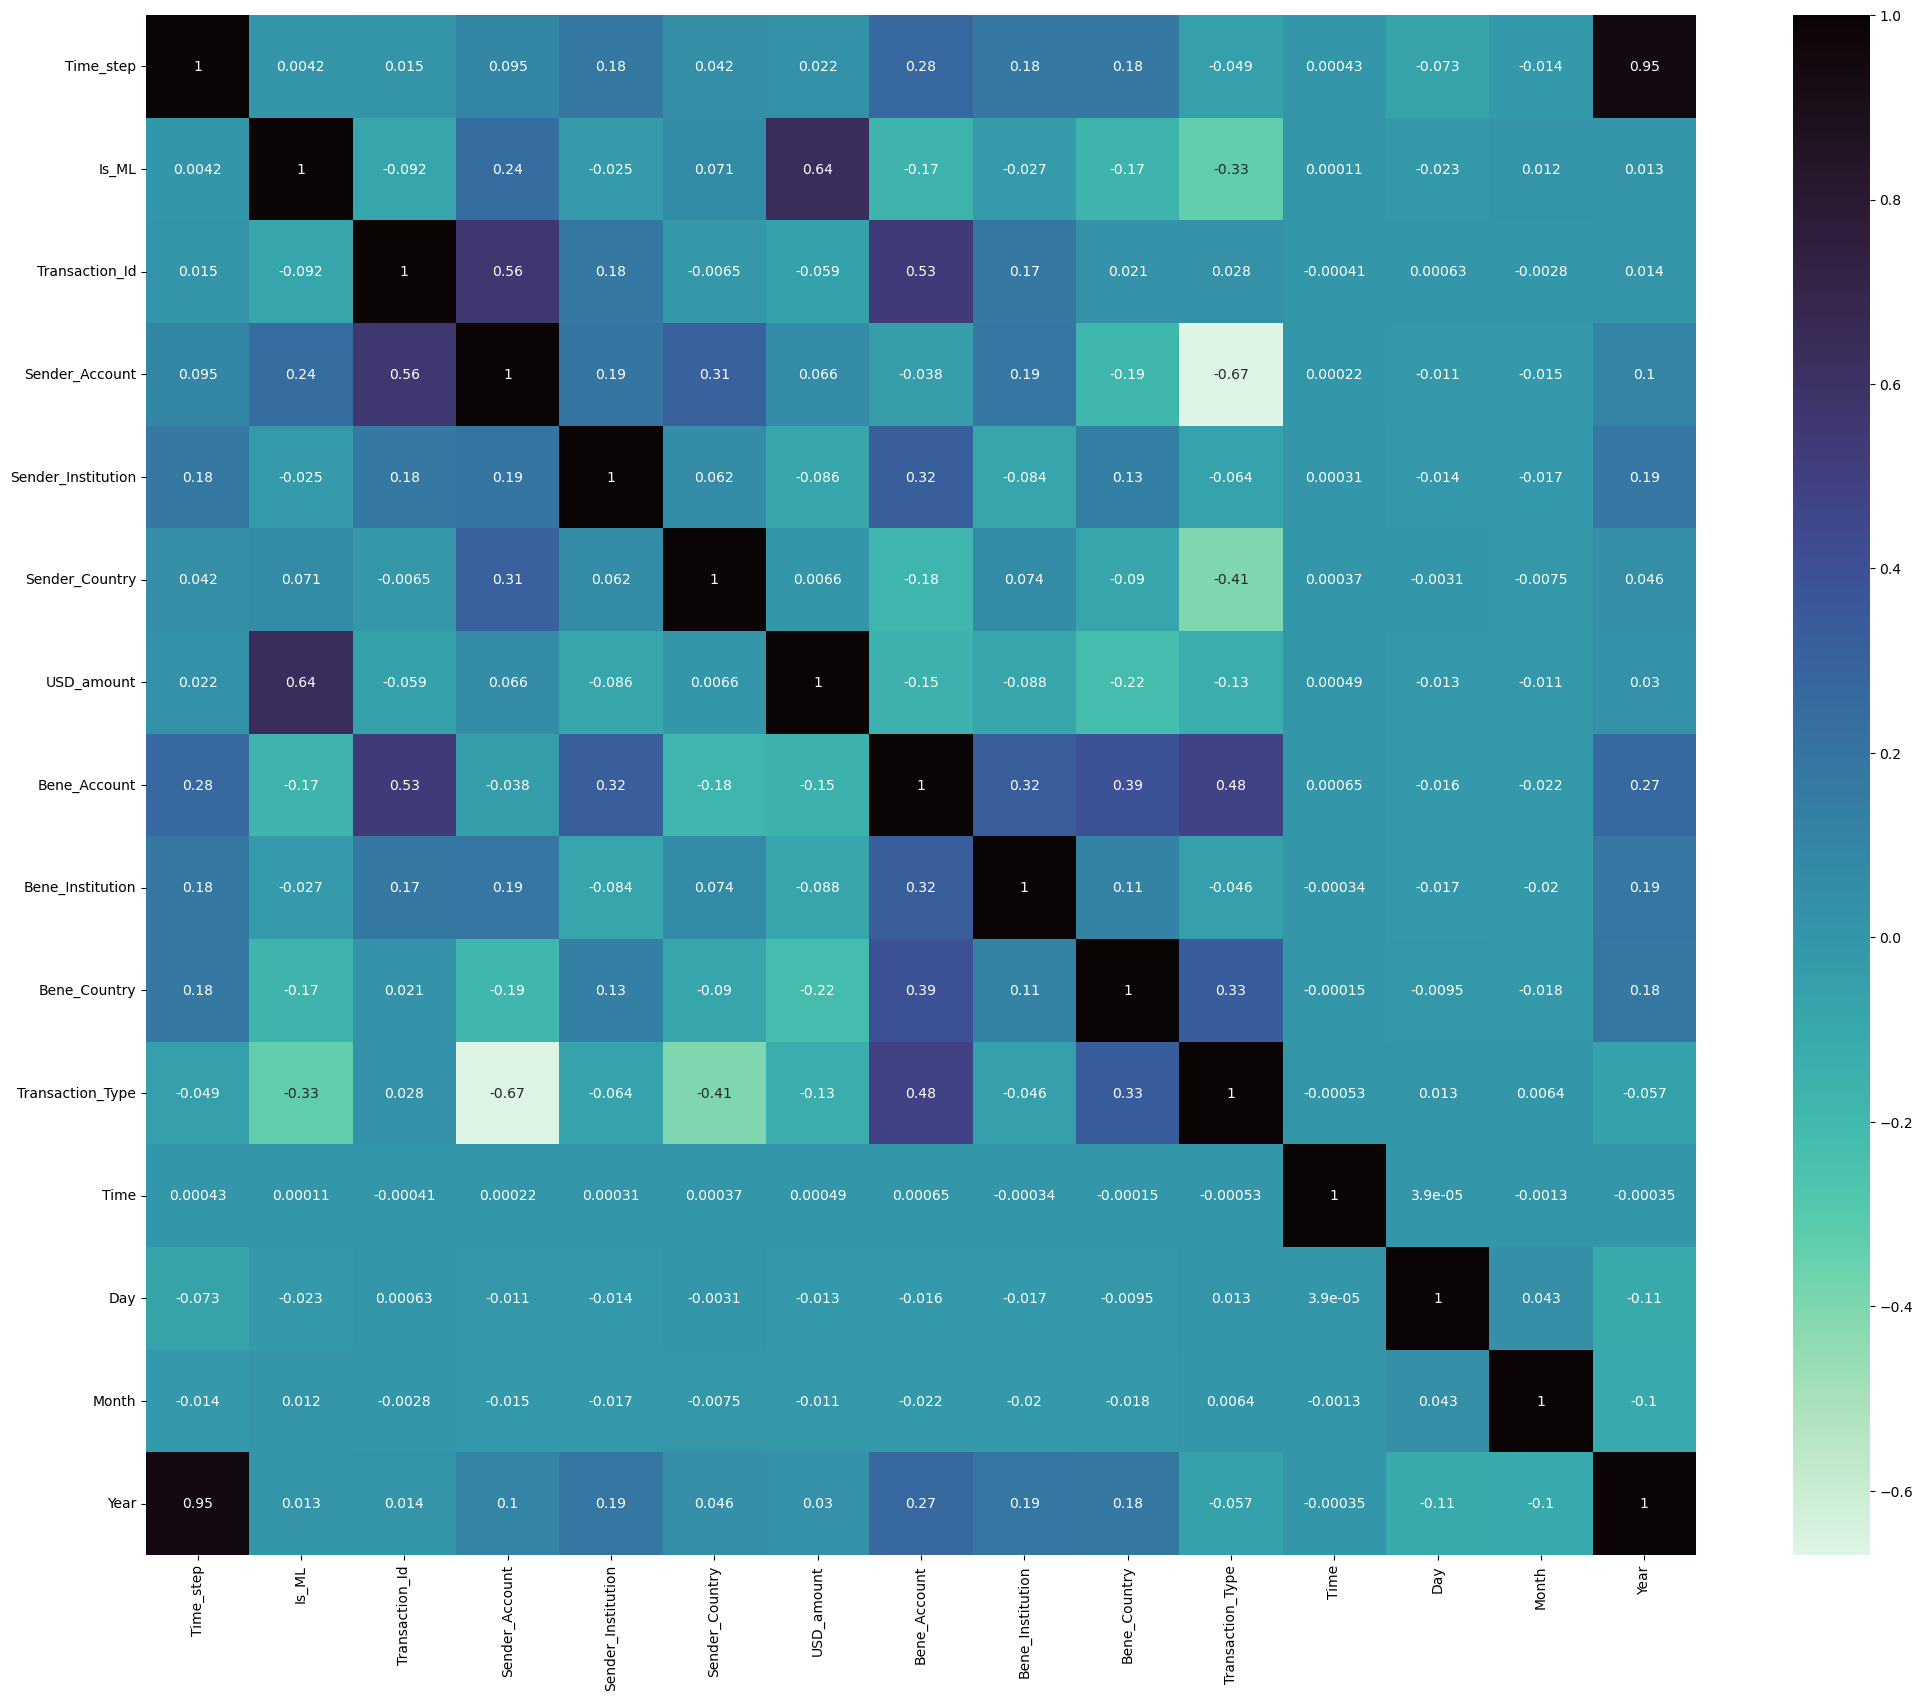

In [86]:
# Plot the correlation heatmap
plt.figure(figsize=(25,20))
sns.heatmap(data.corr(), annot=True, cmap="mako_r")

## Predictive Modelling

In [82]:
x = data.drop("Is_ML", axis=1)
y = data["Is_ML"]

#### Feature selection:
- select top 5 feature that are highly correlated to the target variable.

In [83]:
select_feature = SelectKBest(k=5)
select_feature.fit_transform(x,y)

ValueError: could not convert string to float: '2022-01-07 00:02:00'

In [48]:
# Top 5 features highly correlated
select_feature.get_feature_names_out()

AttributeError: 'SelectKBest' object has no attribute 'scores_'

In [ ]:
x = x[select_feature.get_feature_names_out()]

In [ ]:
x.shape

split into training and set validation to 80:20 ratio

In [40]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [41]:
x_train.shape, y_train.shape,x_test.shape,y_test.shape

((1187628, 15), (1187628,), (296908, 15), (296908,))

In [42]:
# The imbalanced dataset
y.value_counts()

0    1173586
1     310950
Name: Is_ML, dtype: int64

In [43]:
def model_performance_eval(model,test_data):
    prediction = model.predict(test_data)
    print(f"Validation Accuracy : {accuracy_score(y_test,prediction)} %")
    print(f"Precision Score : {precision_score(y_test,prediction)}%")
    print(f"Recall Score : {recall_score(y_test,prediction)}%")
    print(f"F1 Score : {f1_score(y_test,prediction)}%")
    print(Classification_report(y_test,prediction))        

In [ ]:
# Random Forest model without balancing the data
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(x_train,y_train)

In [ ]:
# Measure performance the model
model_performance_eval(rand_forest,x_test)

The model is not performing well because of the imbalance in the dataset, we need to reduce TN,FN and increase the TP,FP. 

### Data Resampling

since the class distribution is imbalanced in the target variable, I will resample the trainig set using oversampling.
The oversampling method chosen for the project is Synthetic Minority Oversampling Technique (SMOTE) and Edited Nearest Neighbor (ENN). The two combined are reffered to as SMOTEEEN.

In [94]:
# Sample data
x_st, y_st = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_clusters_per_class=1, n_samples=1000, random_state=42)


In [95]:
# Display class distribution before resampling
print("Class distribution before resampling:", Counter(y))


Class distribution before resampling: Counter({0: 1173586, 1: 310950})


In [97]:
# Initialize the SMOTE-ENN object
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

# Apply SMOTE-ENN to the data
x_st_resampled, y_st_resampled = smote_enn.fit_resample(x_st, y_st)

# Display class distribution after resampling
print("Class distribution after resampling:", Counter(y_st_resampled))


Class distribution after resampling: Counter({0: 896, 1: 857})


In [ ]:
y_st.value_counts()

In [ ]:
y_st.value_counts().plot(kind="bar")

Th SMOTEEEN sampling method was able to balance our dataset

In [ ]:
# Split the dataset into train using the balanced dataset
x_train,x_test,y_train,y_test = train_test_split(x_st,y_st,test_size=0.3,random_state=42)

In [99]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1187628, 15), (296908, 15), (1187628,), (296908,))

In [100]:
# Parameter grid
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

In [ ]:
grid = GridSearchCV(rand_forest,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(x,y)


In [ ]:
# grid search results
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))
print('Best grid search score is: '+str(model_grid.best_score_))


In [ ]:
# random search cv
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
          }

In [ ]:
rand_forest = RandomForestClassifier()

random_search_cv = RandomizedSearchCV(rand_forest, rs_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
model_random = random_search_cv.fit(x,y)


In [ ]:
# random search results
print('Best random search hyperparameters are: '+str(model_random.best_params_))
print('Best random search score is: '+str(model_random.best_score_))